In [146]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm


# orders = """
# with base as 
# (
#         SELECT
#                  ord.country_code
#                  ,city_name
#                 ,customer_zone.id AS zone_id
#                 ,ord.order_placed_at created_at
#                 ,ord.platform_order_code
#                 ,ord.dps_surge_fee_eur
#                 ,ord.dps_standard_fee_eur
#                 ,ord.dps_delivery_fee_eur
#                 ,ord.dps_mean_delay
#                 ,ord.mean_delay
#                 ,ord.mean_delay_orders
#                 ,ord.actual_delivery_time
#                 ,ord.order_delay_mins
#                 ,(ord.actual_delivery_time - ord.order_delay_mins) expected_delivery_time
#         FROM fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders ord, UNNEST(ord.customer_zones) AS customer_zone
#         WHERE ord.created_date >= '2024-09-01'
#         AND ord.created_date <= '2024-09-07'
#         AND ord.country_code = 'bd'
#         AND city_name = 'Dhaka'
#         AND ord.is_own_delivery
# )
# select   country_code
#         ,city_name
#         ,zone_id
#         ,TIMESTAMP_ADD(
#         TIMESTAMP '1990-01-01T00:00:00', 
#         INTERVAL CAST(FLOOR(TIMESTAMP_DIFF(created_at, TIMESTAMP '1990-01-01T00:00:00', MINUTE) / 30) AS INT64) * 30 MINUTE
#         ) AS created
#         ,count(distinct platform_order_code) total_orders
#         ,sum(dps_surge_fee_eur) total_surge
#         ,avg(dps_surge_fee_eur) avg_surge
#         ,sum(dps_standard_fee_eur) total_standard_fee
#         ,avg(dps_standard_fee_eur) avg_standard_fee
#         ,sum(dps_delivery_fee_eur) total_delivery_fee
#         ,avg(dps_delivery_fee_eur) avg_delivery_fee
#         ,avg(dps_mean_delay) avg_dps_mean_delay
#         ,avg(mean_delay) avg_mean_delay
#         ,avg(mean_delay_orders) avg_mean_delay_orders
#         ,avg(actual_delivery_time) avg_actual_delivery_time
#         ,avg(order_delay_mins) avg_order_delay_mins
#         ,avg(expected_delivery_time) avg_expected_delivery_time
# from base
# group by 1,2,3,4
# """

details  = """
with sessions as (
SELECT  ss.entity_id
       ,ss.country_code
       ,c zone_id
       ,ss.dps_city_name city_name
       ,ss.dps_city_id
       ,FORMAT('%02d:%02d',
        EXTRACT(HOUR FROM TIMESTAMP_ADD(
            TIMESTAMP '1990-01-01T00:00:00', 
            INTERVAL CAST(FLOOR(TIMESTAMP_DIFF(created_at, TIMESTAMP '1990-01-01T00:00:00', MINUTE) / 30) AS INT64) * 30 MINUTE
        )),
        EXTRACT(MINUTE FROM TIMESTAMP_ADD(
            TIMESTAMP '1990-01-01T00:00:00', 
            INTERVAL CAST(FLOOR(TIMESTAMP_DIFF(created_at, TIMESTAMP '1990-01-01T00:00:00', MINUTE) / 30) AS INT64) * 30 MINUTE
        ))
    ) AS created
       ,count(distinct perseus_session_id) total_sessions
       ,count(distinct perseus_client_id) total_users
FROM fulfillment-dwh-production.cl.dps_cvr_events_perseus ss,UNNEST(SPLIT(dps_zones_id)) c
WHERE ss.created_date >= '2024-09-01'
AND ss.created_date <= '2024-09-30'
AND ss.country_code = 'bd'
and ss.dps_city_name = 'Dhaka'
group by 1,2,3,4,5,6
),
orders as ( 
        with base as 
(
        SELECT
                 ord.country_code
                 ,city_name
                ,dps_mean_delay_zone_id zone_id
                ,ord.order_placed_at created_at
                ,ord.platform_order_code
                ,(case when is_sent = True then platform_order_code else null end) as completed_order
                ,ord.dps_surge_fee_eur
                ,ord.dps_standard_fee_eur
                ,ord.dps_delivery_fee_eur
                ,ord.dps_mean_delay
                ,ord.mean_delay
                ,ord.mean_delay_orders
                ,ord.actual_delivery_time
                ,ord.order_delay_mins
                ,(ord.actual_delivery_time - ord.order_delay_mins) expected_delivery_time
        FROM fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders ord
        WHERE ord.created_date >= '2024-09-01'
        AND ord.created_date <= '2024-09-30'
        AND ord.country_code = 'bd'
        AND city_name = 'Dhaka'
        AND ord.is_own_delivery
)
select   country_code
        ,city_name
        ,zone_id
        ,FORMAT('%02d:%02d',
        EXTRACT(HOUR FROM TIMESTAMP_ADD(
            TIMESTAMP '1990-01-01T00:00:00', 
            INTERVAL CAST(FLOOR(TIMESTAMP_DIFF(created_at, TIMESTAMP '1990-01-01T00:00:00', MINUTE) / 30) AS INT64) * 30 MINUTE
        )),
        EXTRACT(MINUTE FROM TIMESTAMP_ADD(
            TIMESTAMP '1990-01-01T00:00:00', 
            INTERVAL CAST(FLOOR(TIMESTAMP_DIFF(created_at, TIMESTAMP '1990-01-01T00:00:00', MINUTE) / 30) AS INT64) * 30 MINUTE
        ))
        ) AS created
        ,count(distinct platform_order_code) total_orders
        ,count(distinct completed_order) total_completed_orders
        ,sum(dps_surge_fee_eur) total_surge
        ,avg(dps_surge_fee_eur) avg_surge
        ,sum(dps_standard_fee_eur) total_standard_fee
        ,avg(dps_standard_fee_eur) avg_standard_fee
        ,sum(dps_delivery_fee_eur) total_delivery_fee
        ,avg(dps_delivery_fee_eur) avg_delivery_fee
        ,avg(dps_mean_delay) avg_dps_mean_delay
        ,avg(mean_delay) avg_mean_delay
        ,avg(mean_delay_orders) avg_mean_delay_orders
        ,avg(actual_delivery_time) avg_actual_delivery_time
        ,avg(order_delay_mins) avg_order_delay_mins
        ,avg(expected_delivery_time) avg_expected_delivery_time
from base
group by 1,2,3,4
),
zone_stats as (
  SELECT  z.country_code
       ,z.zone_id
       ,FORMAT('%02d:%02d',
        EXTRACT(HOUR FROM TIMESTAMP_ADD(
            TIMESTAMP '1990-01-01T00:00:00', 
            INTERVAL CAST(FLOOR(TIMESTAMP_DIFF(created_at, TIMESTAMP '1990-01-01T00:00:00', MINUTE) / 30) AS INT64) * 30 MINUTE
        )),
        EXTRACT(MINUTE FROM TIMESTAMP_ADD(
            TIMESTAMP '1990-01-01T00:00:00', 
            INTERVAL CAST(FLOOR(TIMESTAMP_DIFF(created_at, TIMESTAMP '1990-01-01T00:00:00', MINUTE) / 30) AS INT64) * 30 MINUTE
        ))
        ) AS created
       ,avg(s.mean_delay) average_mean_delay 
       ,sum(s.accepteds_count) accepted_orders
       ,sum(s.dispatcheds_count) dispatched_orders
       ,sum(s.queueds_count) queued_orders
       ,sum(s.drop_off_count) delivered_orders
       ,sum(s.couriers_count) total_riders
       ,sum(s.couriers_starting_count) number_of_riders_starting_shift
       ,sum(s.couriers_ending_count) number_of_riders_ending_shift
FROM fulfillment-dwh-production.cl.zone_stats z, UNNEST(stats) s
WHERE z.created_date >= '2024-09-01'
AND z.created_date <= '2024-09-07'
AND z.country_code = 'bd'
group by 1,2,3
)

select s.*
       ,o.* except(country_code, city_name, zone_id,created)
       ,z.* except(country_code, zone_id,created)
from sessions s
join orders o on o.country_code = s.country_code and cast(o.zone_id as int) = cast(s.zone_id as int) and o.created = s.created
join zone_stats z on z.country_code = s.country_code and cast(z.zone_id as int) = cast(s.zone_id as int) and z.created = s.created
"""


# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

test_df = client.query(details).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [147]:
test_df.columns

Index(['entity_id', 'country_code', 'zone_id', 'city_name', 'dps_city_id',
       'created', 'total_sessions', 'total_users', 'total_orders',
       'total_completed_orders', 'total_surge', 'avg_surge',
       'total_standard_fee', 'avg_standard_fee', 'total_delivery_fee',
       'avg_delivery_fee', 'avg_dps_mean_delay', 'avg_mean_delay',
       'avg_mean_delay_orders', 'avg_actual_delivery_time',
       'avg_order_delay_mins', 'avg_expected_delivery_time',
       'average_mean_delay', 'accepted_orders', 'dispatched_orders',
       'queued_orders', 'delivered_orders', 'total_riders',
       'number_of_riders_starting_shift', 'number_of_riders_ending_shift'],
      dtype='object')

<Axes: xlabel='total_riders'>

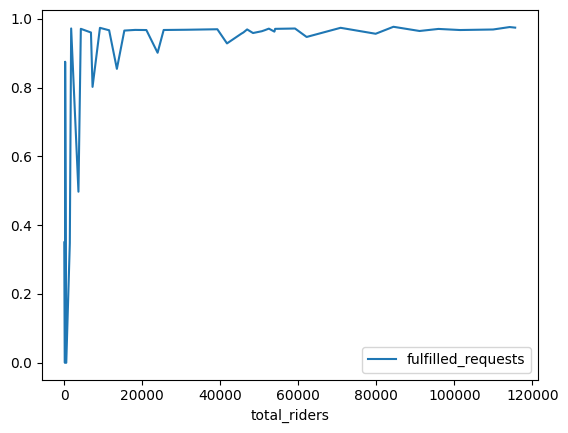

In [181]:
a = test_df[test_df['zone_id'] == '14']
b = a.groupby('total_riders').agg({'fulfilled_requests':'mean'}).reset_index()

b.plot(x = 'total_riders', y = 'fulfilled_requests')

In [176]:
b

,total_riders,avg_expected_delivery_time


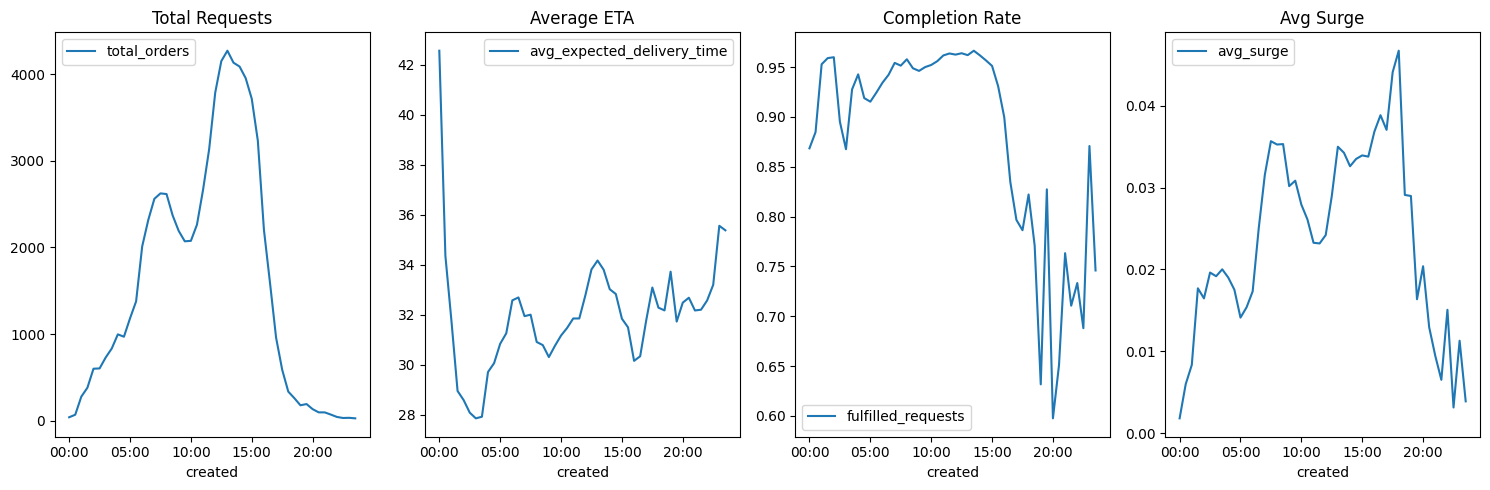

In [149]:
test_df['conversion'] = test_df['total_orders'] / test_df['total_sessions']
test_df['fulfilled_requests'] = test_df['total_completed_orders'] / test_df['total_orders']

df = test_df.groupby('created').agg({'total_orders':'mean','avg_expected_delivery_time':'mean','fulfilled_requests':'mean','avg_surge':'mean'}).reset_index()

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot on each subplot
df.plot(x='created', y='total_orders'y, ax=axes[0], title="Total Requests")
df.plot(x='created', y='avg_expected_delivery_time', ax=axes[1], title="Average ETA")
df.plot(x='created', y='fulfilled_requests', ax=axes[2], title="Completion Rate")
df.plot(x='created', y='avg_surge', ax=axes[3], title="Avg Surge")


# Show the plots
plt.tight_layout()
plt.show()

In [150]:
# filter_df = test_df[~test_df['avg_expected_delivery_time'].isna()]

# filter_df['avg_expected_delivery_time'] = filter_df['avg_expected_delivery_time'].round(0)
# filter_df['avg_mean_delay_orders'] = filter_df['avg_mean_delay_orders'].round()
# filter_df['avg_dps_mean_delay'] = filter_df['avg_dps_mean_delay'].round()
# filter_df['avg_mean_delay'] = filter_df['avg_mean_delay'].round()
# filter_df['avg_surge'] = pd.to_numeric(filter_df['avg_surge'], errors='coerce')
# filter_df['avg_surge'] = filter_df['avg_surge'].round(2)
# filter_df['total_standard_fee'] = filter_df['avg_surge'].round(2)


# grouped_d = filter_df.groupby('avg_expected_delivery_time').agg({'total_orders':'mean'}).reset_index()

# grouped_d.plot(x = 'avg_expected_delivery_time', y = 'total_orders')

,avg_mean_delay,conversion
0,-3.0,0.058824
1,-2.0,0.090296
2,-1.0,0.081481
3,-0.0,0.086583
4,1.0,0.154383
5,2.0,0.17216
6,3.0,0.29747
7,4.0,0.164452
8,5.0,1.565631
9,6.0,2.480864


In [27]:
filter_df['avg_surge'].round(1)

0       0.017812500
1       0.015000000
2       0.020357143
3       0.011048387
4       0.016746032
           ...     
5069    0.073846154
5070           0E-9
5071           0E-9
5072           0E-9
5073           0E-9
Name: avg_surge, Length: 5003, dtype: object